In [1]:
import sys
sys.path.append("creation_functions")

### Notebook Goals
- Try to understand how to implement a "leave-one-out" technique based on subjects
- Test and compare a classifier performance without this custom cross validation and the normal shuffling

In [2]:
from creation_functions.utilities import preprocessing
import pandas as pd
import numpy as np

In [3]:
prepr_dataset = preprocessing(pd.read_csv("collapsed_dataset.csv", index_col=0))
prepr_dataset = prepr_dataset.sample(frac=1)

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier


In [5]:
def get_a_split(dataframe, who_to_leave_out):
    train_data = dataframe.loc[dataframe["subject"] != who_to_leave_out]
    test_data = dataframe.loc[dataframe["subject"] == who_to_leave_out]
    train_labels = train_data["class"]
    test_labels = test_data["class"]
    train_data = train_data.drop(["class", "subject", "trial"], axis=1)
    test_data = test_data.drop(["class", "subject", "trial"], axis=1)
    return train_data, test_data, train_labels, test_labels

In [6]:
def custom_cross_validation(dataframe, classifier):
    a = range(1, 25)
    permutation = np.random.permutation(a)
    y_pred = []
    y_true = []
    for i in permutation:
        X_train, X_test, y_train, y_test = get_a_split(dataframe,i)
        y_true.append(y_test)
        classifier.fit(X_train, y_train)
        y_pred.append(classifier.predict(X_test))
    return permutation, y_true, y_pred

In [7]:
steps = [
    ("scaler", RobustScaler()),
    ("sampler", SMOTE()),
    ("selection", SelectKBest(k=20)),
    ("classification", RandomForestClassifier())
]
pipeline = Pipeline(steps)

In [8]:
results = cross_validate(
    pipeline,
    prepr_dataset.drop(["class", "trial", "subject"], axis=1),
    prepr_dataset["class"],
    cv = KFold(shuffle=True, random_state=15, n_splits=10),
    scoring={
        "accuracy" : make_scorer(accuracy_score),
        "f1-score" : make_scorer(f1_score, average="weighted")
    },
    return_estimator=True
)

In [9]:
print(f'Mean Accuracy with normal Cross Validation: {results["test_accuracy"].mean()}')

Mean Accuracy with normal Cross Validation: 0.922077132035046


In [10]:
print(f'Mean f1-score with normal Cross Validation: {results["test_f1-score"].mean()}')

Mean f1-score with normal Cross Validation: 0.9219124430043945


In this type of applications it could be more appropriate to split the dataset on "subjects" instead of considering instances as independent from each other. Even if the accuracy in this way appears to be really high (over 92% with just < 30% of the total number of features), we are allowing to have a strange combination of events: a subject can be considered both in train and in test set. That means that we have a risk of overfitting, because the model could just "see" all subjects in advance and "overtrain" on all of them.

In the following cells, we try to discover if keeping apart an entire subject affects the accuracy of the classifier.

In [11]:
permutation, true_labels, predicted_labels = custom_cross_validation(prepr_dataset, pipeline)

In [12]:
import seaborn as sns
accuracies = []
f1_scores = []
metrics = pd.DataFrame(columns=["accuracy", "f1_score", "without_who"])
for i in range(0,len(true_labels)):
    metrics = metrics.append({"accuracy" : accuracy_score(true_labels[i], predicted_labels[i]), "f1_score" : f1_score(true_labels[i], predicted_labels[i], average="weighted"), "without_who" : int(permutation[i])}, ignore_index=True)
metrics

C:\Users\angel\AppData\Local\Temp\ipykernel_17176\322893607.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"accuracy" : accuracy_score(true_labels[i], predicted_labels[i]), "f1_score" : f1_score(true_labels[i], predicted_labels[i], average="weighted"), "without_who" : int(permutation[i])}, ignore_index=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_17176\322893607.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"accuracy" : accuracy_score(true_labels[i], predicted_labels[i]), "f1_score" : f1_score(true_labels[i], predicted_labels[i], average="weighted"), "without_who" : int(permutation[i])}, ignore_index=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_17176\322893607.py:6: FutureWarning: The frame.append method is deprecated and will be removed f

,accuracy,f1_score,without_who
0,0.917981,0.913993,24.0
1,0.916898,0.915653,6.0
2,0.754667,0.773183,10.0
3,0.904145,0.907068,7.0
4,0.741794,0.745468,19.0
5,0.772727,0.758050,4.0
6,0.830084,0.844082,9.0
7,0.692982,0.631134,23.0
8,0.781250,0.782092,13.0
9,0.841837,0.840755,1.0


In [13]:
metrics["without_who"] = metrics["without_who"].astype(int)

<AxesSubplot: xlabel='without_who', ylabel='accuracy'>

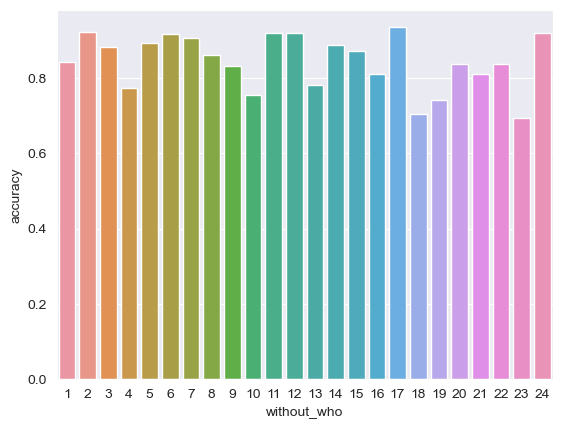

In [14]:
import seaborn as sns
sns.barplot(data=metrics, x="without_who", y="accuracy")

<AxesSubplot: xlabel='without_who', ylabel='f1_score'>

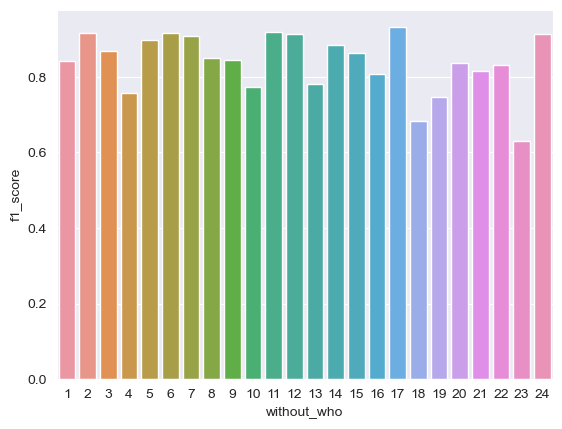

In [15]:
sns.barplot(data=metrics, x="without_who", y="f1_score")

In [16]:
metrics["accuracy"].mean(), metrics["f1_score"].mean()

(0.8431610808245958, 0.8384759701653617)

#### Conclusions
As we can see, the same classifier with the same parameters for all elements in the pipeline show different results. We drop from a really optmistic accuracy of 92-93% to one of 84-85%.
In particular, we have cases in which accuracy drops "drastically". For example, testing on subject 18, accuracy drops below 70%.

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

Accuracy Score testing on subject 24 : 0.917981072555205


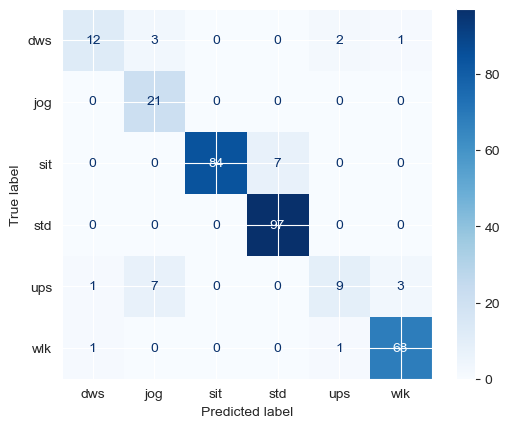

In [18]:
index = metrics.loc[metrics["without_who"] == 24].index
print(f'Accuracy Score testing on subject 24 : {accuracy_score(true_labels[index[0]], predicted_labels[index[0]])}')
ConfusionMatrixDisplay.from_predictions(true_labels[index[0]], predicted_labels[index[0]], cmap="Blues")

**Subject 24 is an interesting case in which the mislabeled activity is jogging**. No other subjects have this number of poor accuracy on this activity, that is usually well separated from other types of activity.
Reading about the experiment, we noticed that subject 24 was the youngest (18 years). Maybe as a young teenager runs while going up or downstairs?